# OTICA

Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from openpyxl import Workbook
import re
import socket
import psutil
import plotly.express as px
import plotly.graph_objects as go 
from dash import Dash, html, dcc, dash_table, Input, Output
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import dash.dependencies as dd
from dash.dash_table.Format import Group
from plotly.subplots import make_subplots

# UPDATE GPTY

Adding Dividend Frequency (Div_Freq) and Strategy (Strategy) to the data frame to be mapped later.  Needs to be done for each unique stock

In [5]:
#dividend frequency column
div_freq_dict = {'T': 'Q', 'GLAD': 'M', 'ARLP': 'Q', 'O': 'M', 'AVGO': 'Q', 'MO': 'Q', 'DX': 'M', 'PFLT': 'Q', 'AQN': 'Q',
                 'ARMK': 'Q', 'MAIN': 'Q', 'NVO': 'SA', 'INTC': 'Q', 'HAFN': 'Q', 'ET': 'Q', 'APLE': 'M', 'SAR': 'Q', 'JEPI': 'M',
                 'IIPR': 'Q', 'STAG': 'M', 'EPD': 'Q', 'FEPI': 'M', 'NWN': 'Q', 'FRT': 'Q', 'SPYI': 'M', 'SVOL': 'M', 'SOXL': 'Q',
                 'EIPI': 'M', 'OARK': 'M', 'SGOV': 'M'
}
div_freq = pd.DataFrame(list(div_freq_dict.items()), columns=['Symbol', 'Div_Freq'])

#strategy column
strat_dict = {  'T': '', 'GLAD': '', 'ARLP': '',  'O': '', 'AVGO': '', 'MO': '', 'DX': '', 'PFLT': '', 'AQN': '',  'ARMK': '',
    'MAIN': '', 'NVO': '', 'INTC': '', 'HAFN': '', 'ET': '', 'APLE': '', 'SAR': '', 'JEPI': '', 'IIPR': '', 'STAG': '', 'EPD': '',
    'FEPI': '', 'NWN': '', 'FRT': '', 'SPYI': '', 'SVOL': '', 'SOXL': '', 'EIPI': '',
    'OARK': ''
}
df1 = pd.DataFrame(list(strat_dict.items()), columns=['Symbol', 'Strategy'])

## Creating/Importing Master 

If entering data in the Portfolio Sheet, go to Robinhood's Investing Overview and copy and paste from the Symbol Column To the end

In [9]:
# Load Portfolio sheet
portfolio = pd.read_excel('newotica.xlsx', sheet_name='Portfolio')

# If portfolio is empty or visually blank, fall back to Master
if portfolio.empty or portfolio.dropna(how='all').empty:
    master = pd.read_excel('newotica.xlsx', sheet_name='Master')

else:
    # Add the column Symbols as the first row
    portfolio.loc[-1] = portfolio.columns
    portfolio.index = portfolio.index + 1
    portfolio = portfolio.sort_index()

    # Extract column Symbols and data
    column_Symbols = portfolio.iloc[:7, 0].tolist()
    data_rows = portfolio.iloc[7:, 0].tolist()

    # Reshape data into rows
    num_columns = len(column_Symbols)
    reshaped_data = [data_rows[i:i + num_columns] for i in range(0, len(data_rows), num_columns)]

    # Create new DataFrame
    portfolio = pd.DataFrame(reshaped_data, columns=column_Symbols)

    # Convert relevant columns to numeric
    for col in ["Price", "Average cost", "Equity", "Total return"]:
        portfolio[col] = pd.to_numeric(portfolio[col], errors='coerce')

    # rename and calculate 'Return'
    portfolio["Return"] = portfolio.apply(
        lambda row: -abs(row['Total return']) if row["Average cost"] > row["Price"] else row["Total return"], axis=1
    )

    # Return %
    portfolio["Return %"] = ((portfolio["Price"] - portfolio["Average cost"]) / portfolio["Average cost"]) * 100
    portfolio["Return %"] = round(portfolio["Return %"], 1)

    # Portfolio %
    total_equity = portfolio['Equity'].sum()
    portfolio['Portfolio %'] = (portfolio['Equity'] / total_equity) * 100
    portfolio['Portfolio %'] = round(portfolio['Portfolio %'], 1)

    # Final master
    master = portfolio.copy()

    # === Fetch Yahoo Finance data ===
    symbols = master['Symbol'].tolist()
    data_dict = {}

    for ticker in symbols:
        try:
            stock = yf.Ticker(ticker)
            data = stock.info
            data_dict[ticker] = data
        except Exception as e:
            print(f"Error fetching data for {ticker}: {e}")
            data_dict[ticker] = {}

    # Convert to DataFrame and merge
    stock_data_df = pd.DataFrame.from_dict(data_dict, orient='index').reset_index()
    stock_data_df.rename(columns={'index': 'Symbol'}, inplace=True)
    master = master.merge(stock_data_df, on='Symbol', how='left')

# Retrieving Historical Stock Price Data

#### IF OFFLINE RUN CODE

In [13]:
output_file = 'portfolio_data.xlsx'

# --- Import back from Excel ---
portfolio_file = output_file
symbol_dataframes = {}

# pd.ExcelFile has .sheet_names (not .sheet_name)
with pd.ExcelFile(portfolio_file) as xls:
    for sheet in xls.sheet_names:
        # read each sheet (you can set index_col=0 if you want to preserve the original index)
        symbol_dataframes[sheet] = pd.read_excel(xls, sheet_name=sheet, index_col=0)

#### IF CONNECTING TO YFinance API

In [15]:
dates = [30, 100, 175]                # Periods for MA and Bollinger Bands
period_range = "10y"                 # Data time range: last 10 years
auto_adjust_prices = True            # Whether to auto-adjust for splits/dividends
rsi_period = 40  

In [16]:
#importing watchlist
watchlist = pd.read_excel('newotica.xlsx', sheet_name='Watchlist')

symbol_dataframes = {}

#for symbol in master['Symbol']:
for symbol in list(master['Symbol']) + ['^GSPC'] + ['^IXIC']+ ['^DJI'] + list(watchlist['Symbol']):
    try:
        print(f"Fetching data for {symbol}...")
        data = yf.download(symbol, period=period_range, auto_adjust=auto_adjust_prices)

        # --- Dynamic Moving Averages & Bollinger Bands ---
        for period in dates:
            ma_col = f'MA{period}'
            std_col = f'BB{period}_Std'
            upper_col = f'BB{period}_Upper'
            lower_col = f'BB{period}_Lower'

            data[ma_col] = data['Close'].rolling(window=period).mean()
            data[std_col] = data['Close'].rolling(window=period).std()
            data[upper_col] = data[ma_col] + (2 * data[std_col])
            data[lower_col] = data[ma_col] - (2 * data[std_col])

        # Drop standard deviation columns
        std_cols = [f'BB{period}_Std' for period in dates]
        data.drop(columns=std_cols, inplace=True)

        # --- MACD ---
        data['EMA12'] = data['Close'].ewm(span=12, adjust=False).mean()
        data['EMA26'] = data['Close'].ewm(span=26, adjust=False).mean()
        data['MACD'] = data['EMA12'] - data['EMA26']
        data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()
        data['MACD_Histogram'] = data['MACD'] - data['Signal_Line']

        # --- RSI ---
        delta = data['Close'].diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        avg_gain = gain.rolling(window=rsi_period, min_periods=rsi_period).mean()
        avg_loss = loss.rolling(window=rsi_period, min_periods=rsi_period).mean()
        rs = avg_gain / avg_loss
        data['RSI'] = 100 - (100 / (1 + rs))

        symbol_dataframes[symbol] = data
    except Exception as e:
        print(f"Failed to fetch data for {symbol}: {e}")

# Cleanup MultiIndex columns if needed
for symbol, df in symbol_dataframes.items():
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]

# Exporting data
output_file = 'portfolio_data.xlsx'
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    for symbol, df in symbol_dataframes.items():
        # Excel sheet Symbols have a 31 character limit and cannot contain some characters.
        # Here, we trim the symbol Symbol if needed.
        sheet_name = symbol[:31]
        df.to_excel(writer, sheet_name=sheet_name)
print(f"Data successfully exported to {output_file}")

Fetching data for AVGO...


[*********************100%***********************]  1 of 1 completed


Fetching data for T...


[*********************100%***********************]  1 of 1 completed


Fetching data for GLAD...


[*********************100%***********************]  1 of 1 completed


Fetching data for O...


[*********************100%***********************]  1 of 1 completed


Fetching data for ARLP...


[*********************100%***********************]  1 of 1 completed


Fetching data for SOXL...


[*********************100%***********************]  1 of 1 completed


Fetching data for MO...


[*********************100%***********************]  1 of 1 completed


Fetching data for DX...


[*********************100%***********************]  1 of 1 completed


Fetching data for PFLT...


[*********************100%***********************]  1 of 1 completed


Fetching data for ARMK...


[*********************100%***********************]  1 of 1 completed


Fetching data for MAIN...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Fetching data for OARK...
Fetching data for FEPI...



[*********************100%***********************]  1 of 1 completed


Fetching data for SPYI...


[*********************100%***********************]  1 of 1 completed


Fetching data for AQN...


[*********************100%***********************]  1 of 1 completed


Fetching data for NVO...


[*********************100%***********************]  1 of 1 completed


Fetching data for SAR...


[*********************100%***********************]  1 of 1 completed


Fetching data for SVOL...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Fetching data for EIPI...
Fetching data for FRT...



[*********************100%***********************]  1 of 1 completed


Fetching data for SGOV...


[*********************100%***********************]  1 of 1 completed


Fetching data for EPD...


[*********************100%***********************]  1 of 1 completed


Fetching data for JEPI...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Fetching data for SCYB...


Fetching data for JEPQ...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching data for GPTY...
Fetching data for HAFN...


[*********************100%***********************]  1 of 1 completed


Fetching data for NWN...


[*********************100%***********************]  1 of 1 completed


Fetching data for INTC...


[*********************100%***********************]  1 of 1 completed


Fetching data for APLE...


[*********************100%***********************]  1 of 1 completed


Fetching data for STAG...


[*********************100%***********************]  1 of 1 completed


Fetching data for ET...


[*********************100%***********************]  1 of 1 completed


Fetching data for IIPR...


[*********************100%***********************]  1 of 1 completed


Fetching data for ^GSPC...


[*********************100%***********************]  1 of 1 completed


Fetching data for ^IXIC...


[*********************100%***********************]  1 of 1 completed


Fetching data for ^DJI...


[*********************100%***********************]  1 of 1 completed


Fetching data for CRWD...


[*********************100%***********************]  1 of 1 completed


Fetching data for PANW...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Fetching data for CRWV...



[*********************100%***********************]  1 of 1 completed

Fetching data for BAM...


Fetching data for BDDY...


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BDDY']: HTTPError('HTTP Error 404: ')
[*********************100%***********************]  1 of 1 completed

Fetching data for ARIS...
Fetching data for EPR...



[*********************100%***********************]  1 of 1 completed


Fetching data for COLD...


[*********************100%***********************]  1 of 1 completed


Fetching data for COLB...


[*********************100%***********************]  1 of 1 completed


Fetching data for UNH...


[*********************100%***********************]  1 of 1 completed


Fetching data for NTST...


[*********************100%***********************]  1 of 1 completed


Fetching data for EXR...


[*********************100%***********************]  1 of 1 completed


Fetching data for OHI...


[*********************100%***********************]  1 of 1 completed


Fetching data for PM...


[*********************100%***********************]  1 of 1 completed


Fetching data for BAT...


[*********************100%***********************]  1 of 1 completed


Fetching data for DLR...


[*********************100%***********************]  1 of 1 completed


Fetching data for AMT...


[*********************100%***********************]  1 of 1 completed


Fetching data for GTO...


[*********************100%***********************]  1 of 1 completed


Fetching data for AXP...


[*********************100%***********************]  1 of 1 completed


Fetching data for PGX...


[*********************100%***********************]  1 of 1 completed


Fetching data for MPW...


[*********************100%***********************]  1 of 1 completed


Fetching data for JEPQ...


[*********************100%***********************]  1 of 1 completed


Fetching data for AEP...


[*********************100%***********************]  1 of 1 completed


Fetching data for MAA...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Fetching data for CONY...
Fetching data for ULTY...



[*********************100%***********************]  1 of 1 completed


Fetching data for TCEHY...


[*********************100%***********************]  1 of 1 completed


Fetching data for NUKZ...


[*********************100%***********************]  1 of 1 completed


Fetching data for nan...
Failed to fetch data for nan: 'float' object has no attribute 'replace'
Fetching data for nan...
Failed to fetch data for nan: 'float' object has no attribute 'replace'
Fetching data for nan...
Failed to fetch data for nan: 'float' object has no attribute 'replace'
Fetching data for nan...
Failed to fetch data for nan: 'float' object has no attribute 'replace'
Fetching data for nan...
Failed to fetch data for nan: 'float' object has no attribute 'replace'
Fetching data for nan...
Failed to fetch data for nan: 'float' object has no attribute 'replace'
Fetching data for nan...
Failed to fetch data for nan: 'float' object has no attribute 'replace'
Fetching data for nan...
Failed to fetch data for nan: 'float' object has no attribute 'replace'
Fetching data for nan...
Failed to fetch data for nan: 'float' object has no attribute 'replace'
Fetching data for nan...
Failed to fetch data for nan: 'float' object has no attribute 'replace'
Fetching data for nan...
Faile

## EXPORTING WHAT MUST GO TO THE CLOUD

In [20]:
master.to_excel('replace_master_sheet.xlsx')

In [118]:
master = pd.read_excel('replace_master_sheet.xlsx')

# Creating Visualizations

In [121]:
accent_color = '#1abc9c'

# BUILDING DASHBORAD TABLE

In [124]:
master['sector'] = np.where(master['sector'].isnull(), 'ETF', master['sector'])
master['industry'] = np.where(master['industry'].isna(), master['Name'], master['industry'])

master['weightedYield'] = master['Equity'] * master['dividendYield']



master[['Symbol','Name', 'industry', 'sector']]

,Symbol,Name,industry,sector
0,AVGO,Broadcom,Semiconductors,Technology
1,T,AT&T,Telecom Services,Communication Services
2,GLAD,Gladstone Capital,Asset Management,Financial Services
3,O,Realty Income,REIT - Retail,Real Estate
4,ARLP,Alliance Resource,Thermal Coal,Energy
5,SOXL,Direxion Daily Semiconductor Bull ETF,Direxion Daily Semiconductor Bull ETF,ETF
6,MO,Altria,Tobacco,Consumer Defensive
7,DX,Dynex Capital,REIT - Mortgage,Real Estate
8,PFLT,PennantPark Floating Rate,Asset Management,Financial Services
9,ARMK,Aramark,Specialty Business Services,Industrials


In [126]:
df_table = master[['Symbol', 'Return %', 'Shares', 'dividendYield', 'Average cost', 'Price', 'payoutRatio',
                   'heldPercentInsiders', 'heldPercentInstitutions', 'bookValue', '52WeekChange']]
#name symbol sector price average cost return% Portfolio % ROIC, Divident yield # ROCI = return on investment capital

## Importing Dividends

This code cell imports all dividend history using "Dividend History" from the Robinhood website.  Only add dividends that have been recieved

In [130]:
# load data
dividends = pd.read_excel('newotica.xlsx', sheet_name='Dividend History')

# STATISTIC = Last 12 Months
latest_date    = dividends['Date'].max()
cutoff_date    = latest_date - pd.DateOffset(months=12)
last_12_months = dividends[dividends['Date'] >= cutoff_date]

dividend_sums = (
    last_12_months
    .groupby('Symbol')['Dividend']
    .sum()
    .reset_index(name='12_Month_Div')
)

# STATISTIC = Total Dividend 
total_div_df = (
    dividends
    .groupby('Symbol')['Dividend']
    .sum()
    .reset_index(name='Total_Div')
)

# STATISTIC = Last Dividend Amount
most_recent_dividends = (
    dividends
    .sort_values(by='Date', ascending=False)
    .drop_duplicates(subset='Symbol', keep='first')
    [['Symbol', 'Dividend']]
    .rename(columns={'Dividend': 'Last_div'})
    .reset_index(drop=True)
)

# merge everything
final_div = (
    total_div_df
    .merge(dividend_sums,           on='Symbol', how='left')
    .merge(most_recent_dividends,   on='Symbol', how='left')
)

final_div.head(5)

,Symbol,Total_Div,12_Month_Div,Last_div
0,APLE,10.80,6.92,1.28
1,AQN,0.17,0.17,0.17
2,ARLP,30.10,18.20,5.60
3,ARMK,0.11,0.11,0.11
4,AVGO,0.59,0.59,0.59


## Importing Transactions

This code cell imports all transaction and deposit history using "Recent" from the Robinhood website.

#### Entering New Data

Must look at robinhood recent

In [136]:
transactions = pd.read_excel('newotica.xlsx', sheet_name='Transactions')
transactions.head(5)

,Action,Symbol,Shares,Price,Total,Date
0,Buy,SCYB,1.0,26.46,26.46,2025-07-24
1,Buy,JEPQ,6.0,55.04,330.26,2025-07-23
2,Buy,SGOV,12.0,100.63,1207.56,2025-07-23
3,Deposit,NaN,NaN,NaN,1400.00,2025-07-23
4,Buy,SGOV,4.0,100.47,401.88,2025-07-10


# Sunburst Charts

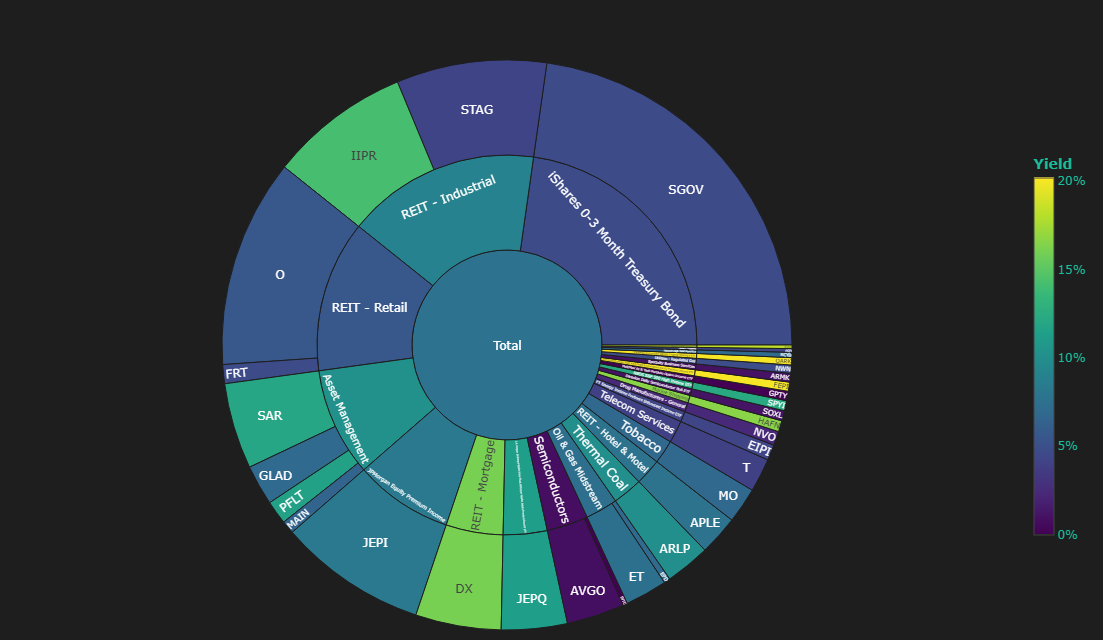

In [139]:
import pandas as pd
import plotly.graph_objects as go

# -----------------------------------------------------------------------------
# Assume `master` is a pandas DataFrame with at least these columns:
#   - 'Symbol'           (string ticker symbols)
#   - 'industry'         (string industry symbols)
#   - 'Equity'           (numeric values for sizing the chart)
#   - 'dividendYield'    (numeric percent in xx.xx format, e.g. 3.45 meaning 3.45%)
#   - 'Return %'         (numeric percent in xx.xx format, e.g. -2.50 meaning -2.50%)
#   - 'recommendationKey' (string recommendation like 'Buy', 'Hold', etc.)
# -----------------------------------------------------------------------------

levels       = ['Symbol', 'industry']
value_column = 'Equity'

# Copy and compute weighted yield
master = master.copy()
master['weightedYield'] = master['Equity'] * master['dividendYield']

total_equity         = master[value_column].sum()
total_weighted       = master['weightedYield'].sum()
total_dividend_yield = total_weighted / total_equity  # overall portfolio yield

def build_hierarchical_dataframe(master: pd.DataFrame, levels: list, value_column: str) -> pd.DataFrame:
    df_list = []
    for i, level in enumerate(levels):
        group_cols = levels[i:]
        agg = (
            master
            .groupby(group_cols)
            .agg({value_column: 'sum', 'weightedYield': 'sum'})
            .reset_index()
        )
        df_tree = pd.DataFrame({
            'id':            agg[level].astype(str),
            'value':         agg[value_column],
            'dividendYield': (agg['weightedYield'] / agg[value_column]).round(2)
        })
        df_tree['parent'] = agg[levels[i+1]].astype(str) if i < len(levels)-1 else 'Total'
        df_tree['% of Portfolio'] = ((df_tree['value'] / total_equity) * 100).round(1)
        df_list.append(df_tree)
    # add Total row
    total_row = {
        'id':             'Total',
        'parent':         '',
        'value':          total_equity,
        '% of Portfolio': 100.0,
        'dividendYield':  round(total_dividend_yield, 2),
    }
    df_list.append(pd.DataFrame([total_row]))
    return pd.concat(df_list, ignore_index=True)

df_all_trees = build_hierarchical_dataframe(master, levels, value_column)

# Map each Symbol’s Return % and recommendationKey; non‐symbol levels stay NaN/blank
return_map = master.set_index('Symbol')['Return %'].to_dict()
rec_map    = master.set_index('Symbol')['recommendationKey'].to_dict()

df_all_trees['Return %']          = df_all_trees['id'].map(return_map)
df_all_trees['recommendationKey'] = df_all_trees['id'].map(rec_map)

# Build hover text: only Symbol rows get Return % & Recommendation
def make_hover(row):
    txt = (
        f"<b>{row['id']}</b><br>"
        f"Equity: ${row['value']:,.2f}<br>"
        f"% of Portfolio: {row['% of Portfolio']:.1f}%"
    )
    if pd.notna(row['dividendYield']):
        txt += f"<br>Dividend Yield: {row['dividendYield']:.2f}%"
    if pd.notna(row['Return %']):
        txt += f"<br>Return %: {row['Return %']:.2f}%"
    if isinstance(row['recommendationKey'], str) and row['recommendationKey']:
        txt += f"<br>Recommendation: {row['recommendationKey']}"
    return txt

df_all_trees['hover_text'] = df_all_trees.apply(make_hover, axis=1)

# Cap dividendYield for coloring
df_all_trees['dividendYield_capped'] = df_all_trees['dividendYield'].clip(upper=20)

# Build and show the Sunburst with original Viridis color scheme
sunburst_fig = go.Figure(go.Sunburst(
    labels=df_all_trees['id'],
    parents=df_all_trees['parent'],
    values=df_all_trees['value'],
    branchvalues='total',
    marker=dict(
        colors=df_all_trees['dividendYield_capped'],
        colorscale='Viridis',
        cmin=0,
        cmax=20.2,
        colorbar=dict(
            title=dict(text="<b>Yield</b>", font=dict(size=14)),
            tickformat=".0f",
            ticksuffix="%",
            tickfont=dict(size=12),
            len=0.7,
            lenmode="fraction",
            thickness=20,
            thicknessmode="pixels",
            y=0.5,
            yanchor="middle"
        )
    ),
    hovertext=df_all_trees['hover_text'],
    hoverinfo='text',
    textinfo='label'
))

# styling
accent_color = '#1abc9c'
sunburst_fig.update_layout(
    title=dict(text="", font=dict(size=20, color=accent_color), x=0.5, xanchor='center'),
    paper_bgcolor='#1e1e1e',
    plot_bgcolor='#1e1e1e',
    font_color=accent_color,
    margin=dict(t=60, b=10, r=10, l=10),
    height=640,
    width=680,
)

sunburst_fig.show()


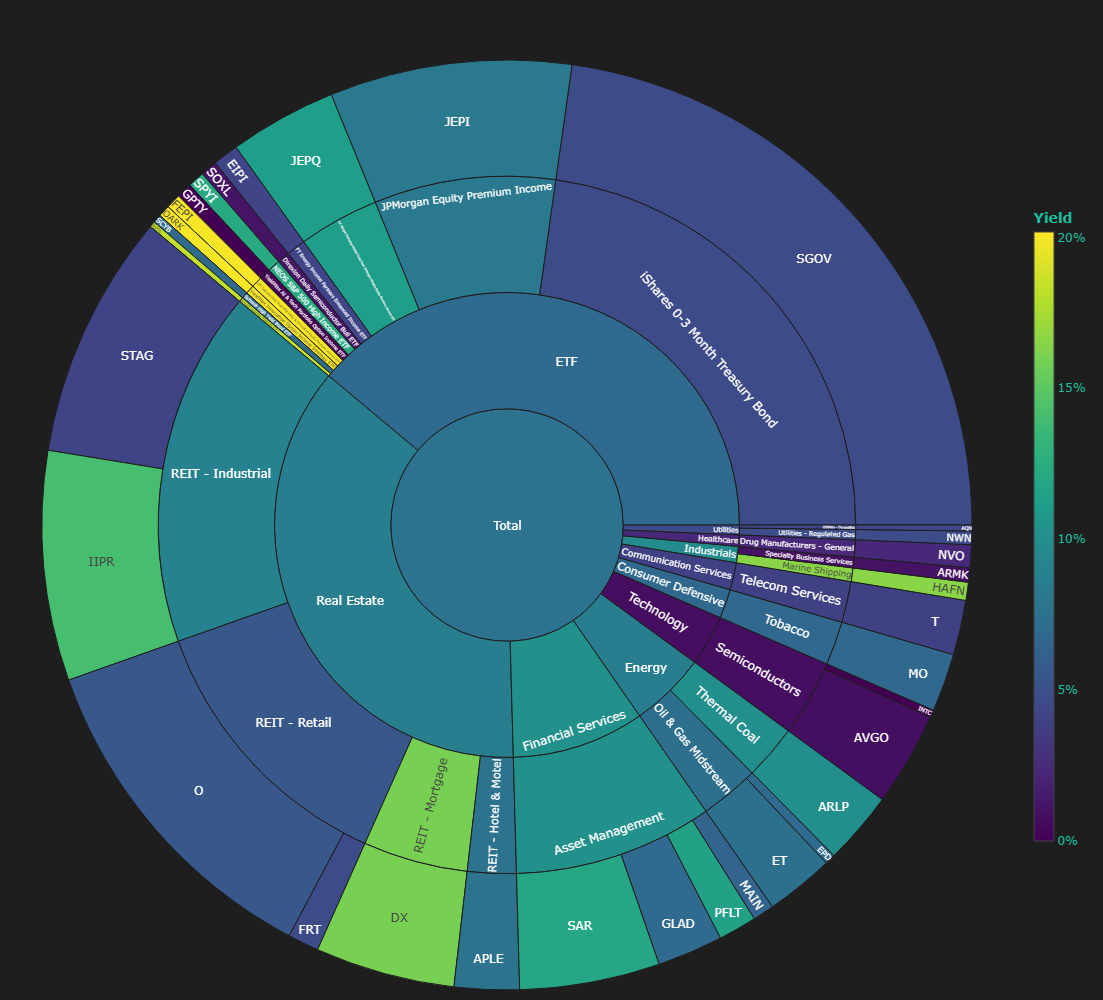

In [169]:
import pandas as pd
import plotly.graph_objects as go

# -----------------------------------------------------------------------------
# Assume `master` is a pandas DataFrame with at least these columns:
#   - 'Symbol'           (string ticker symbols)
#   - 'industry'         (string industry names)
#   - 'sector'           (string sector names)
#   - 'Equity'           (numeric values for sizing the chart)
#   - 'dividendYield'    (numeric percent in xx.xx format, e.g. 3.45 meaning 3.45%)
#   - 'Return %'         (numeric percent in xx.xx format, e.g. -2.50 meaning -2.50%)
#   - 'recommendationKey' (string recommendation like 'Buy', 'Hold', etc.)
# -----------------------------------------------------------------------------

# Define the hierarchy levels (from leaf up to just below Total)
levels       = ['Symbol', 'industry', 'sector']
value_column = 'Equity'

# Copy and compute weighted yield
master = master.copy()
master['weightedYield'] = master['Equity'] * master['dividendYield']

total_equity         = master[value_column].sum()
total_weighted       = master['weightedYield'].sum()
total_dividend_yield = total_weighted / total_equity  # overall portfolio yield

def build_hierarchical_dataframe(master: pd.DataFrame, levels: list, value_column: str) -> pd.DataFrame:
    df_list = []
    for i, level in enumerate(levels):
        group_cols = levels[i:]
        agg = (
            master
            .groupby(group_cols)
            .agg({value_column: 'sum', 'weightedYield': 'sum'})
            .reset_index()
        )
        df_tree = pd.DataFrame({
            'id':            agg[level].astype(str),
            'value':         agg[value_column],
            'dividendYield': (agg['weightedYield'] / agg[value_column]).round(2)
        })
        # the next level up is the parent; if at top of levels, parent is "Total"
        df_tree['parent'] = agg[levels[i+1]].astype(str) if i < len(levels)-1 else 'Total'
        df_tree['% of Portfolio'] = ((df_tree['value'] / total_equity) * 100).round(1)
        df_list.append(df_tree)
    # add the Total root node
    total_row = {
        'id':             'Total',
        'parent':         '',
        'value':          total_equity,
        '% of Portfolio': 100.0,
        'dividendYield':  round(total_dividend_yield, 2),
    }
    df_list.append(pd.DataFrame([total_row]))
    return pd.concat(df_list, ignore_index=True)

# Build the full hierarchical dataframe
df_all_trees = build_hierarchical_dataframe(master, levels, value_column)

# Map each Symbol’s Return % and recommendationKey; non‐symbol levels stay NaN/blank
return_map = master.set_index('Symbol')['Return %'].to_dict()
rec_map    = master.set_index('Symbol')['recommendationKey'].to_dict()

df_all_trees['Return %']          = df_all_trees['id'].map(return_map)
df_all_trees['recommendationKey'] = df_all_trees['id'].map(rec_map)

# Build hover text: only Symbol rows get Return % & Recommendation
def make_hover(row):
    txt = (
        f"<b>{row['id']}</b><br>"
        f"Equity: ${row['value']:,.2f}<br>"
        f"% of Portfolio: {row['% of Portfolio']:.1f}%"
    )
    if pd.notna(row['dividendYield']):
        txt += f"<br>Dividend Yield: {row['dividendYield']:.2f}%"
    if pd.notna(row['Return %']):
        txt += f"<br>Return %: {row['Return %']:.2f}%"
    if isinstance(row['recommendationKey'], str) and row['recommendationKey']:
        txt += f"<br>Recommendation: {row['recommendationKey']}"
    return txt

df_all_trees['hover_text'] = df_all_trees.apply(make_hover, axis=1)

# Cap dividendYield for coloring
df_all_trees['dividendYield_capped'] = df_all_trees['dividendYield'].clip(upper=20)

# Build and show the Sunburst
sunburst_fig = go.Figure(go.Sunburst(
    labels=df_all_trees['id'],
    parents=df_all_trees['parent'],
    values=df_all_trees['value'],
    branchvalues='total',
    marker=dict(
        colors=df_all_trees['dividendYield_capped'],
        colorscale='Viridis',
        cmin=0,
        cmax=20.2,
        colorbar=dict(
            title=dict(text="<b>Yield</b>", font=dict(size=14)),
            tickformat=".0f",
            ticksuffix="%",
            tickfont=dict(size=12),
            len=0.7,
            lenmode="fraction",
            thickness=20,
            thicknessmode="pixels",
            y=0.5,
            yanchor="middle"
        )
    ),
    hovertext=df_all_trees['hover_text'],
    hoverinfo='text',
    textinfo='label'
))

# Styling
accent_color = '#1abc9c'
sunburst_fig.update_layout(
    title=dict(text="", font=dict(size=20, color=accent_color), x=0.5, xanchor='center'),
    paper_bgcolor='#1e1e1e',
    plot_bgcolor='#1e1e1e',
    font_color=accent_color,
    margin=dict(t=60, b=10, r=10, l=10),
    height=1000,
    width=1000,
)

sunburst_fig.show()


# Dividends

In [172]:
dividends = pd.read_excel('newotica.xlsx', sheet_name='Dividend History')

In [174]:
# 1. Convert the 'Date' column to datetime
dividends['Date'] = pd.to_datetime(dividends['Date'])

# 2. Create a 'YearMonth' column in the format 'YYYY-MM'
dividends['YearMonth'] = dividends['Date'].dt.strftime('%Y-%m')

# 3. Group the data by 'YearMonth' and 'Symbol' and sum the 'Dividend'
grouped_dividends = dividends.groupby(['YearMonth', 'Symbol'], as_index=False)['Dividend'].sum()

# Compute total dividend per YearMonth across all symbols
total_dividends = dividends.groupby('YearMonth', as_index=False)['Dividend'].sum()

# 4. Create a stacked bar chart using Plotly Express
fig_dividends = px.bar(
    grouped_dividends,
    x='YearMonth',
    y='Dividend',
    color='Symbol',
    title='',
    barmode='stack'
)

# 5. Add annotations for totals above each bar using the accent color and making the text bold
for i, row in total_dividends.iterrows():
    fig_dividends.add_annotation(
        x=row['YearMonth'],             # X-position at the corresponding YearMonth
        y=row['Dividend'],              # Y-position at the total dividend (stacked bar height)
        text=f"<b>{row['Dividend']:.2f}</b>",  # Bold text annotation
        showarrow=False,
        yshift=10,                      # Shift the text 10 pixels above the bar for clarity
        font=dict(
            color=accent_color,         # Use the accent color
            size=12
        ),
        align="center"
    )

# 6. Update the layout for a dark theme with smaller margins and no axis labels
fig_dividends.update_layout(
    paper_bgcolor='#1e1e1e',
    plot_bgcolor='#1e1e1e',
    font_color=accent_color,
    margin=dict(t=20, b=20, l=20, r=20),
    xaxis_title=None,  # remove x-axis label
    yaxis_title= 'Dividends ($)'   # remove y-axis label
)

# 7. Update axes:
#    - For the y-axis: add grid lines every 5 (colored gray) and ensure the zero line is gray.
#    - For the x-axis: remove additional gridlines and only show the zero line (colored gray).
fig_dividends.update_yaxes(dtick=5, gridcolor='gray', zeroline=True, zerolinecolor='gray')
fig_dividends.update_xaxes(showgrid=False, zeroline=True, zerolinecolor='gray')

# Dividends by Symbol

In [176]:
import pandas as pd
import plotly.express as px

# 1. (Optional) If you haven’t already, convert 'Date' to datetime
dividends['Date'] = pd.to_datetime(dividends['Date'])

# 2. Group by 'Symbol' and sum the 'Dividend'
symbol_totals = (
    dividends
    .groupby('Symbol', as_index=False)['Dividend']
    .sum()
    .sort_values('Dividend', ascending=False)
)

# 3. Create a bar chart of total dividends per symbol
fig_symbols = px.bar(
    symbol_totals,
    x='Symbol',
    y='Dividend',
    title='',
    color_discrete_sequence=[accent_color]
)

# 4. Add annotations above each bar
for idx, row in symbol_totals.iterrows():
    fig_symbols.add_annotation(
        x=row['Symbol'],
        y=row['Dividend'],
        text=f"<b>{row['Dividend']:.1f}</b>",
        showarrow=False,
        yshift=8,
        font=dict(color='orange', size=12),
        align='center'
    )

# 5. Apply your dark theme & layout tweaks
fig_symbols.update_layout(
    paper_bgcolor='#1e1e1e',
    plot_bgcolor='#1e1e1e',
    font_color=accent_color,
    margin=dict(t=30, b=20, l=20, r=20),
    xaxis_title=None,
    yaxis_title='Total Dividends ($)'
)

# 6. Gridlines & zero lines
fig_symbols.update_yaxes(dtick=10, gridcolor='gray', zeroline=True, zerolinecolor='gray')
fig_symbols.update_xaxes(showgrid=False, zeroline=True, zerolinecolor='gray')

fig_symbols.show()


# Returns

Need to review

In [179]:
transactions = pd.read_excel('newotica.xlsx', sheet_name='Transactions')

In [180]:
# --- 1) Load and normalize transactions ---
tx = transactions.copy()
tx['Date']   = pd.to_datetime(tx['Date'])
tx['Action'] = tx['Action'].str.strip().str.title()

# Separate trades and compute signed shares
trades = tx[tx['Action'].isin(['Buy', 'Sell'])].copy()
trades['SignedShares'] = np.where(trades['Action']=='Buy',
                                  trades['Shares'],
                                  -trades['Shares'])

# --- 2) Full daily index ---
start = trades['Date'].min()
end   = pd.to_datetime('today').normalize()
dates = pd.date_range(start, end, freq='D')
positions = pd.DataFrame(index=dates)

# --- 3) Build daily position values ---
for sym, hist_df in symbol_dataframes.items():
    df = hist_df.copy()
    # ensure datetime index
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
    else:
        df.index = pd.to_datetime(df.index)
    
    # forward-filled daily close
    price = df['Close'].reindex(dates).ffill().fillna(0)
    
    # cumulative shares held
    tx_sym = trades.loc[trades['Symbol']==sym, ['Date','SignedShares']].set_index('Date')
    shares = tx_sym['SignedShares'].reindex(dates).fillna(0).cumsum()
    
    positions[f'{sym}_value'] = shares * price

# --- 4) Compute total return in dollars ---
positions['StocksValue'] = positions.filter(like='_value').sum(axis=1)
deposits = tx.loc[tx['Action']=='Deposit'].set_index('Date')['Total'].reindex(dates).fillna(0)
positions['Cash'] = deposits.cumsum()
positions['TotalReturn'] = positions['StocksValue']  # since cash cancels out

# --- 5) Plot with Plotly ---
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=positions.index,
    y=positions['TotalReturn'],
    mode='lines',
    line=dict(color=accent_color, width=2),
    name='Total Return ($)'
))
fig.add_hline(
    y=0,
    line=dict(color='grey', dash='dash')
)
fig.update_layout(
    title='Portfolio Value',
    xaxis_title='Date',
    yaxis_title='Value ($)',
    template='plotly_dark',
    showlegend=False,
    width=1020,
    height=350,
    font=dict(color=accent_color),
    margin=dict(l=40, r=20, t=50, b=40)
)
fig.show()

# Returns

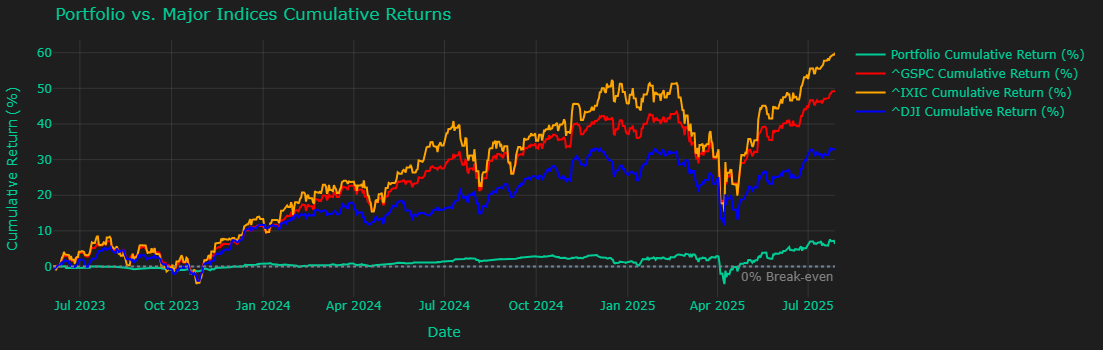

In [185]:
import pandas as pd
import plotly.graph_objects as go

# 0) style / colors
accent_color    = '#00CC96'   # your portfolio line color
benchmark_color = 'red'       # S&P line color
nasdaq_color    = 'orange'    # NASDAQ line color
dow_color       = 'blue'      # Dow Jones line color

benchmark_symbol = '^GSPC'
nasdaq_symbol    = '^IXIC'
dow_symbol       = '^DJI'

# 1) Prepare transactions
transactions['Date'] = pd.to_datetime(transactions['Date'])
transactions = (
    transactions
    .sort_values('Date')
    .reset_index(drop=True)
)
tx_by_date = transactions.groupby('Date')

# 2) Build the full date index
start_date = transactions['Date'].min()
max_price_date = max(df.index.max() for df in symbol_dataframes.values())
end_date = max(transactions['Date'].max(), max_price_date)
all_dates = pd.date_range(start=start_date, end=end_date, freq='D')

# 3) Build a daily price series for each symbol
daily_prices = {}
for sym, df in symbol_dataframes.items():
    df_daily = (
        df
        .sort_index()
        .reindex(all_dates, method='ffill')
    )
    daily_prices[sym] = df_daily

# 4) Run the portfolio simulation
daily_sim = pd.DataFrame(index=all_dates, columns=[
    'Cash','MarketValue','TotalReturns','CumulativeDeposits','NetReturns'
], dtype=float)

cash_balance = 0.0
cumulative_deposits = 0.0
positions = {}

for date in all_dates:
    if date in tx_by_date.groups:
        for _, row in tx_by_date.get_group(date).iterrows():
            action = row['Action']
            if action == 'Deposit':
                amt = row['Total']
                cash_balance += amt
                cumulative_deposits += amt
            elif action == 'Buy':
                cash_balance -= row['Total']
                positions[row['Symbol']] = positions.get(row['Symbol'], 0) + row['Shares']
            elif action == 'Sell':
                cash_balance += row['Total']
                positions[row['Symbol']] = positions.get(row['Symbol'], 0) - row['Shares']

    market_val = sum(
        qty * daily_prices[sym].loc[date, 'Close']
        for sym, qty in positions.items()
        if sym in daily_prices
    )
    total_val = cash_balance + market_val
    net_ret = total_val - cumulative_deposits

    daily_sim.loc[date] = [
        cash_balance,
        market_val,
        total_val,
        cumulative_deposits,
        net_ret
    ]

# 5) compute portfolio cumulative return pct
denominator = cumulative_deposits + cash_balance
daily_sim['CumulativeReturnPct'] = daily_sim['NetReturns'] / denominator * 100

# helper to build benchmark returns
def get_cum_returns(symbol):
    df = (
        symbol_dataframes[symbol]
        .sort_index()
        .reindex(all_dates, method='ffill')
    )
    df['DailyReturn'] = df['Close'].pct_change().fillna(0)
    df['CumulativeReturn'] = (1 + df['DailyReturn']).cumprod() - 1
    return df['CumulativeReturn'] * 100

# 6) compute each benchmark's cumulative returns
sp_returns    = get_cum_returns(benchmark_symbol)
nasdaq_returns = get_cum_returns(nasdaq_symbol)
dow_returns    = get_cum_returns(dow_symbol)

# 7) build the Plotly figure
fig2 = go.Figure()

# portfolio line
fig2.add_trace(go.Scatter(
    x=daily_sim.index,
    y=daily_sim['CumulativeReturnPct'],
    mode='lines',
    name='Portfolio Cumulative Return (%)',
    line=dict(width=2, color=accent_color)
))

# S&P 500 line
fig2.add_trace(go.Scatter(
    x=sp_returns.index,
    y=sp_returns,
    mode='lines',
    name=f'{benchmark_symbol} Cumulative Return (%)',
    line=dict(width=2, color=benchmark_color)
))

# NASDAQ Composite line
fig2.add_trace(go.Scatter(
    x=nasdaq_returns.index,
    y=nasdaq_returns,
    mode='lines',
    name=f'{nasdaq_symbol} Cumulative Return (%)',
    line=dict(width=2, color=nasdaq_color)
))

# Dow Jones line
fig2.add_trace(go.Scatter(
    x=dow_returns.index,
    y=dow_returns,
    mode='lines',
    name=f'{dow_symbol} Cumulative Return (%)',
    line=dict(width=2, color=dow_color)
))

# break‑even horizontal
fig2.add_hline(
    y=0,
    line=dict(color='grey', dash='dot'),
    annotation_text='0% Break‑even',
    annotation_position='bottom right',
    annotation_font_color='grey'
)

# layout styling
fig2.update_layout(
    title='Portfolio vs. Major Indices Cumulative Returns',
    title_font_color=accent_color,
    xaxis=dict(
        title='Date',
        title_font_color=accent_color,
        tickfont_color=accent_color,
        gridcolor='rgba(255,255,255,0.1)'
    ),
    yaxis=dict(
        title='Cumulative Return (%)',
        title_font_color=accent_color,
        tickfont_color=accent_color,
        gridcolor='rgba(255,255,255,0.1)'
    ),
    font=dict(color=accent_color),
    template='plotly_dark',
    paper_bgcolor='#1e1e1e',
    plot_bgcolor='#1e1e1e',
    width=1025,
    height=350,
    margin=dict(l=20, r=20, t=40, b=20),
    showlegend=True
)

fig2.show()


# Stock History Chart

In [188]:
import re
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px  # for the qualitative color palette

# assume accent_color, symbol_dataframes, master, and transactions are defined elsewhere

def generate_stock_chart(symbol):
    # 1) grab your pre-computed df
    df = symbol_dataframes[symbol].reset_index()
    df['Date'] = pd.to_datetime(df['Date'])
    
    # 1a) DROP WEEKENDS (and any non-Mon–Fri dates)
    df = df[df['Date'].dt.weekday < 5]

    # 2) signed-log MACD
    df['MACD_slog']      = np.sign(df['MACD']) * np.log1p(np.abs(df['MACD']))
    df['Signal_slog']    = np.sign(df['Signal_Line']) * np.log1p(np.abs(df['Signal_Line']))
    df['MACD_Hist_slog'] = np.sign(df['MACD_Histogram']) * np.log1p(np.abs(df['MACD_Histogram']))

    # 3) build the 6-row subplot
    fig = make_subplots(
        rows=6, cols=1,
        shared_xaxes=True,
        row_heights=[0.55, 0.02, 0.15, 0.126, 0.014, 0.14],
        vertical_spacing=0.03,
        specs=[[{}],[None],[{}],[{}],[{}],[{}]]
    )

    # ── Row 1: Close price ────────────────────────────────────
    fig.add_trace(go.Scatter(
        x=df['Date'], y=df['Close'], name='Close',
        mode='lines', line=dict(color=accent_color, width=2)
    ), row=1, col=1)

    # dashed avg cost line + label ABOVE the line
    avg_series = master.loc[master['Symbol'] == symbol, 'Average cost']
    if not avg_series.empty:
        avg_cost = avg_series.iloc[0]
        fig.add_hline(
            y=avg_cost,
            line=dict(color='grey', dash='dash'),
            row=1, col=1,
            annotation_text=f"Avg Cost ${avg_cost:.2f}",
            annotation_position="top left",
            annotation_font=dict(color='grey'),
            annotation_bgcolor="rgba(0,0,0,0)"
        )

    # ── Moving Averages ───────────────────────────────────────
    ma_cols = sorted([c for c in df.columns if re.match(r'^MA\d+$', c)],
                     key=lambda c: int(c[2:]))
    ma_colors = px.colors.qualitative.Plotly
    max_period = max((int(c[2:]) for c in ma_cols), default=None)
    for ma in ma_cols:
        period = int(ma[2:])
        if period == max_period:
            color = 'yellow'
            visible = True
        else:
            color = ma_colors[ma_cols.index(ma) % len(ma_colors)]
            visible = 'legendonly'
        fig.add_trace(go.Scatter(
            x=df['Date'], y=df[ma], name=ma,
            mode='lines', line=dict(color=color, width=1.5),
            visible=visible
        ), row=1, col=1)

    # ── Bollinger Bands ──────────────────────────────────────
    bb_ups  = sorted([c for c in df.columns if c.endswith('_Upper')],
                     key=lambda c: int(re.search(r'\d+', c).group()))
    bb_lows = sorted([c for c in df.columns if c.endswith('_Lower')],
                     key=lambda c: int(re.search(r'\d+', c).group()))
    greys = [f'#{v:02x}{v:02x}{v:02x}' for v in np.linspace(128, 200, len(bb_ups), dtype=int)]
    periods = [int(re.search(r'\d+', up).group()) for up in bb_ups]
    max_bb = max(periods) if periods else None
    for up, lo, grey in zip(bb_ups, bb_lows, greys):
        period = int(re.search(r'\d+', up).group())
        is_max = (period == max_bb)
        fig.add_trace(go.Scatter(
            x=df['Date'], y=df[up], name=f'BB{period}', legendgroup=f'BB{period}',
            mode='lines', line=dict(color=grey, dash='dot'),
            visible=is_max
        ), row=1, col=1)
        fig.add_trace(go.Scatter(
            x=df['Date'], y=df[lo], showlegend=False, legendgroup=f'BB{period}',
            mode='lines', line=dict(color=grey, dash='dot'),
            visible=is_max
        ), row=1, col=1)

    fig.update_yaxes(title_text="Price", row=1, col=1)

    # ── Transaction markers ───────────────────────────────────
    tx = transactions[transactions['Symbol'] == symbol].copy()
    if 'Dates' in tx.columns:
        tx = tx.rename(columns={'Dates': 'Date'})
    tx['Date'] = pd.to_datetime(tx['Date'])
    df_prices = df.set_index('Date')[['Close']].sort_index()
    trading_dates = df_prices.index
    pos = trading_dates.searchsorted(tx['Date'])
    tx['PlotDate'] = [trading_dates[i] if i < len(trading_dates) else pd.NaT for i in pos]
    tx = tx.dropna(subset=['PlotDate'])
    tx['Close'] = tx['PlotDate'].map(df_prices['Close'])
    buys  = tx[tx['Action']=='Buy']
    sells = tx[tx['Action']=='Sell']
    if not buys.empty:
        fig.add_trace(go.Scatter(
            x=buys['PlotDate'], y=buys['Close'], name='Buy',
            mode='markers', marker=dict(symbol='x', size=12, color='red')
        ), row=1, col=1)
    if not sells.empty:
        fig.add_trace(go.Scatter(
            x=sells['PlotDate'], y=sells['Close'], name='Sell',
            mode='markers', marker=dict(symbol='circle', size=12, color='green')
        ), row=1, col=1)

    # ── Row 3: RSI ────────────────────────────────────────────
    fig.add_trace(go.Scatter(
        x=df['Date'], y=df['RSI'], name='RSI',
        mode='lines', line=dict(color=accent_color, width=1.5)
    ), row=3, col=1)
    fig.update_yaxes(range=[0,100], title_text="RSI", row=3, col=1)
    fig.add_hline(
        y=70,
        line=dict(color='grey', dash='dash'),
        row=3, col=1,
        annotation_text="Overbought",
        annotation_font=dict(color='grey'),
        annotation_position="top left",
        annotation_bgcolor="rgba(0,0,0,0)"
    )
    fig.add_hline(
        y=30,
        line=dict(color='grey', dash='dash'),
        row=3, col=1,
        annotation_text="Oversold",
        annotation_font=dict(color='grey'),
        annotation_position="bottom left",
        annotation_bgcolor="rgba(0,0,0,0)"
    )

    # ── Row 4: Volume ─────────────────────────────────────────
    volume_cap = df['Volume'].quantile(0.98)
    df['Capped_Volume'] = np.clip(df['Volume'], None, volume_cap)
    fig.add_trace(go.Scatter(
        x=df['Date'], y=df['Capped_Volume'], name='Volume',
        mode='lines', line=dict(color=accent_color, width=1.5)
    ), row=4, col=1)
    fig.update_yaxes(title_text="Volume", showgrid=False, row=4, col=1)

    # ── Row 6: MACD & Signal & Hist ───────────────────────────
    fig.add_trace(go.Scatter(
        x=df['Date'], y=df['MACD_slog'], name='MACD',
        mode='lines', line=dict(color='blue', width=1.5)
    ), row=6, col=1)
    fig.add_trace(go.Scatter(
        x=df['Date'], y=df['Signal_slog'], name='Signal',
        mode='lines', line=dict(color='red', width=1.5)
    ), row=6, col=1)
    fig.add_trace(go.Bar(
        x=df['Date'], y=df['MACD_Hist_slog'], name='Hist',
        marker_color=['green' if v >= 0 else 'red' for v in df['MACD_Hist_slog']]
    ), row=6, col=1)
    fig.update_yaxes(title_text="MACD", row=6, col=1)
    fig.add_hline(y=0, line=dict(color='grey', dash='dash'), row=6, col=1)

    # ── Hide weekends & format x-axis tick labels ────────────
    for r in [1,3,4,5,6]:
        fig.update_xaxes(
            rangebreaks=[dict(bounds=["sat","mon"])],
            tickformat="%b %Y",
            row=r, col=1,
            showticklabels=(r == 1)
        )

    # ── Final layout tweaks ────────────────────────────────────
    fig.update_layout(
        template='plotly_dark',
        paper_bgcolor='#1e1e1e', plot_bgcolor='#1e1e1e',
        font_color=accent_color,
        margin=dict(t=20, b=20, l=20, r=20),
        height=600,
        legend=dict(traceorder='grouped', tracegroupgap=10,
                    orientation='v', x=1.02, y=1)
    )

    return fig

# Usage:
#fig = generate_stock_chart("AVGO")
#fig.show()

# World Figure

In [192]:
import pandas as pd
import time
from geopy.geocoders import Nominatim
import plotly.express as px

# — 1) Build full address strings for geocoding
master['address'] = (
    master['city'].astype(str) + ', ' +
    master['state'].astype(str) + ' ' +
    master['zip'].astype(str) + ', ' +
    master['country'].astype(str)
)

# — 2) Geocode via OpenStreetMap (Nominatim) with 1 request/sec
geolocator = Nominatim(user_agent="your_app_name_here")
lats, lons = [], []
for addr in master['address']:
    try:
        loc = geolocator.geocode(addr, timeout=10)
        if loc:
            lats.append(loc.latitude)
            lons.append(loc.longitude)
        else:
            lats.append(None)
            lons.append(None)
    except Exception:
        lats.append(None)
        lons.append(None)
    time.sleep(1)

master['lat'] = lats
master['lon'] = lons

# — 3) Filter out any rows we couldn’t geocode
map_df = master.dropna(subset=['lat','lon'])

# — 4) Plot on a larger world‐map
world_fig = px.scatter_geo(
    map_df,
    lat='lat',
    lon='lon',
    hover_name='Symbol',
    hover_data={'city':True, 'state':True, 'country':True},
    projection="natural earth",
    title="Headquarters Locations by Symbol",
    width=1000,
    height=600
)

world_fig.update_traces(marker=dict(size=10, color='orange'))
world_fig.update_layout(
    geo=dict(showland=True, landcolor=accent_color),
    margin=dict(l=0, r=0, t=50, b=0)
)

world_fig.show()

# News Scroll

In [194]:
# ─── Cell: headlines + build dictionaries ───
import feedparser

class HeadlineFetcher:
    """
    Fetches up to `max_items` headlines each from Yahoo Finance RSS
    and Reuters (via Google News RSS) for a single company.
    """
    def __init__(self, name, symbol=None, max_items=2):
        self.name      = name
        self.symbol    = symbol or name
        self.max_items = max_items

    def fetch_yahoo(self):
        url  = f"https://finance.yahoo.com/rss/headline?s={self.symbol}"
        feed = feedparser.parse(url)
        return [
            {
                'source': 'Yahoo',
                'symbol': self.symbol,
                'title': entry.title,
                'url':   entry.link
            }
            for entry in feed.entries[:self.max_items]
        ]

    def fetch_reuters(self):
        query = self.name.replace(" ", "+")
        url   = f"https://news.google.com/rss/search?q={query}%20site:reuters.com"
        feed  = feedparser.parse(url)
        return [
            {
                'source': 'Reuters',
                'symbol': self.symbol,
                'title': entry.title,
                'url':   entry.link
            }
            for entry in feed.entries[:self.max_items]
        ]

    def fetch_all(self):
        return self.fetch_yahoo() + self.fetch_reuters()

# Instantiate one fetcher per row and build your HEADLINES list
fetchers = [
    HeadlineFetcher(row["Name"], row.get("Symbol"), max_items=2)
    for _, row in master.iterrows()
]

HEADLINES = []
for fetcher in fetchers:
    HEADLINES.extend(fetcher.fetch_all())

# Now `HEADLINES` is a list of dicts:
# [{'source':'Yahoo','symbol':'AAPL','title':...,'url':...}, ...]
# You can pass this straight into your Dash layout for the ticker.


# Last Day Percent Change Scroll

In [196]:
import numpy as np
import pandas as pd

def get_last_day_pct_change(symbol_dataframes):
    """
    Returns a pandas Series indexed by symbol, with the percent change
    in Close from the previous day to the last day (or NaN if not available).
    """
    data = {}
    for symbol, df in symbol_dataframes.items():
        if df.shape[0] < 2:
            data[symbol] = np.nan
        else:
            prev, last = df['Close'].iloc[-2], df['Close'].iloc[-1]
            data[symbol] = (last - prev) / prev * 100 if prev != 0 else np.nan
    return pd.Series(data, name="LastDayPctChange")

# Usage
changes = get_last_day_pct_change(symbol_dataframes)

# Key Statistics

In [198]:
# 1) Ensure 'Total' is numeric
transactions['Total'] = pd.to_numeric(transactions['Total'], errors='coerce')

# 2) Compute total deposits (only deposits count as your contributions)
total_deposits = transactions.loc[transactions['Action'] == 'Deposit', 'Total'].sum()

# 3) Manually enter your current cash balance
cash = 2.27  # ← update this manually as needed

# 4) Compute current equity from master
investments = master['Equity'].sum()

# 5) Total portfolio value
portfolio = investments + cash

# 6) Absolute return
return_value = portfolio - total_deposits

# 7) Percentage return
if total_deposits != 0:
    total_return_pct = (return_value / total_deposits) * 100
else:
    total_return_pct = np.nan

# 8) Display results
print(f"Total deposits:      ${total_deposits:,.2f}")
print(f"Current equity:      ${investments:,.2f}")
print(f"Cash on hand:        ${cash:,.2f}")
print(f"Portfolio value:     ${portfolio:,.2f}")
print(f"Total return:        ${return_value:,.2f}")
print(f"Total return %:      {total_return_pct:.2f}%")

Total deposits:      $8,100.00
Current equity:      $8,840.96
Cash on hand:        $2.27
Portfolio value:     $8,843.23
Total return:        $743.23
Total return %:      9.18%


# Displaying in Dash App

In [200]:
import socket
import pandas as pd
import time
from geopy.geocoders import Nominatim
import plotly.express as px
import plotly.io as pio
from dash import Dash, dcc, html, dash_table
from dash.dependencies import Input, Output

# -----------------------------------------------------------------------------
# Assume HEADLINES exists: list of dicts with keys 'source','symbol','title','url'
# Assume `changes` exists: a pd.Series indexed by symbol, with percent-change floats

# -----------------------------------------------------------------------------
def get_free_port():
    s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    s.bind(('127.0.0.1', 0))
    _, port = s.getsockname()
    s.close()
    return port

# -----------------------------------------------------------------------------
accent_color = '#1abc9c'
panel_bg     = '#222222'
header_bg    = '#333333'
cell_bg      = '#262626'

pio.templates.default = "plotly_dark"
def apply_dark_layout(fig):
    fig.update_layout(
        template="plotly_dark",
        paper_bgcolor=panel_bg,
        plot_bgcolor=panel_bg
    )
    return fig

# -----------------------------------------------------------------------------
# Layout constants
CONTAINER_PADDING    = '20px'
CONTAINER_GAP        = '20px'
ELEMENT_PADDING      = '10px'
BORDER_RADIUS        = '6px'
BOX_SHADOW           = '2px 2px 6px rgba(0,0,0,0.5)'
SUNBURST_ROW_HEIGHT  = '70vh'
TABLE_HEIGHT_PX      = 450
DIVIDENDS_HEIGHT_PX  = 450
SYMBOL_CHART_HEIGHT  = 450
DROPDOWN_WIDTH       = '300px'
HEADER_FONT_SIZE     = '36px'
STATS_FONT_SIZE      = '16px'

# -----------------------------------------------------------------------------
# Your static figures & data stubs:
# sunburst_fig, fig, fig2, fig_dividends, fig_symbols,
# df_table, cash, investments, return_value, symbol_dataframes,
# world_fig, generate_stock_chart(symbol) …

sunburst_fig   = apply_dark_layout(sunburst_fig)
fig            = apply_dark_layout(fig)
fig2           = apply_dark_layout(fig2)
fig_dividends  = apply_dark_layout(fig_dividends)
fig_symbols    = apply_dark_layout(fig_symbols)
world_fig      = apply_dark_layout(world_fig)

# -----------------------------------------------------------------------------
# Initialize Dash
app = Dash(__name__)

@app.callback(
    Output('watchlist-chart','figure'),
    Input('watchlist-dropdown','value')
)
def update_watchlist_chart(symbol):
    return generate_stock_chart(symbol)

# -----------------------------------------------------------------------------
# Inline CSS & ultra-slow tickers
port = get_free_port()
app.index_string = f"""<!DOCTYPE html>
<html>
<head>
  {{%metas%}}
  <title>{{%title%}}</title>
  {{%favicon%}}
  {{%css%}}
  <style>
    html, body, #root {{ height:100%; margin:0; }}

    /* News ticker */
    #news-ticker-outer {{
      background:#333; color:white;
      overflow:hidden; white-space:nowrap;
      border-bottom:2px solid {accent_color};
      padding:5px 0; font-size:16px; font-family:sans-serif;
    }}
    #news-ticker-inner {{
      display:inline-block;
      padding-left:100%;
      animation: scroll-left 700s linear infinite;
    }}

    /* Change ticker */
    #change-ticker-outer {{
      background:#222; color:white;
      overflow:hidden; white-space:nowrap;
      border-bottom:2px solid {accent_color};
      padding:5px 0; font-size:16px; font-family:sans-serif;
    }}
    #change-ticker-inner {{
      display:inline-block;
      padding-left:100%;
      animation: scroll-left 100s linear infinite;
    }}

    @keyframes scroll-left {{
      0%   {{ transform: translateX(0%); }}
      100% {{ transform: translateX(-100%); }}
    }}
  </style>
</head>
<body>
  {{%app_entry%}}
  <footer>
    {{%config%}}{{%scripts%}}{{%renderer%}}
  </footer>
</body>
</html>"""

# -----------------------------------------------------------------------------
# App layout
app.layout = html.Div(
    style={'backgroundColor': panel_bg, 'padding': CONTAINER_PADDING, 'minHeight': '100vh'},
    children=[

        # — News ticker —
        html.Div(
            html.Div(
                children=[
                    html.Span([
                        f"{h['symbol']} ({h['source']}): {h['title']} ",
                        html.A("link", href=h['url'], target="_blank"),
                        html.Span("  ")
                    ]) for h in HEADLINES
                ],
                id="news-ticker-inner"
            ),
            id="news-ticker-outer"
        ),

        # — Change ticker (percent moves) —
        html.Div(
            html.Div(
                children=[
                    html.Span([
                        f"{sym}: ",
                        html.Span(
                            f"{changes[sym]:.2f}% {'▲' if changes[sym]>=0 else '▼'}",
                            style={'color': 'green' if changes[sym]>=0 else 'red', 'fontWeight': 'bold'}
                        ),
                        html.Span("  ")
                    ]) for sym in changes.index
                ],
                id="change-ticker-inner"
            ),
            id="change-ticker-outer"
        ),

        # — Banner with title & stats —
        html.Div(
            style={
                'backgroundColor': accent_color,
                'padding': f'12px {CONTAINER_PADDING}',
                'textAlign': 'center',
                'borderRadius': BORDER_RADIUS,
                'width': '100%',
                'marginBottom': CONTAINER_GAP
            },
            children=[
                html.H1(
                    "Otica",
                    style={
                        'margin': 0,
                        'fontSize': HEADER_FONT_SIZE,
                        'fontWeight': 'bold',
                        'color': 'black',
                        'lineHeight': '1'
                    }
                ),
                html.Div(
                    f"Cash: ${cash:,.2f}   |   "
                    f"Total Equity: ${investments:,.2f}   |   "
                    f"Total Return: ${return_value:,.2f}",
                    style={
                        'fontSize': STATS_FONT_SIZE,
                        'marginTop': '4px',
                        'color': 'black'
                    }
                )
            ]
        ),

        # — Row: Sunburst + Two Stacked Charts —
        html.Div(
            style={
                'display': 'flex',
                'gap': CONTAINER_GAP,
                'height': SUNBURST_ROW_HEIGHT,
                'marginBottom': CONTAINER_GAP,
                'boxSizing': 'border-box'
            },
            children=[

                # Sunburst panel
                html.Div(
                    style={
                        'flex': '0 0 40%',
                        'maxWidth': '40%',
                        'overflow': 'hidden',
                        'backgroundColor': panel_bg,
                        'border': f'1px solid {accent_color}',
                        'borderRadius': BORDER_RADIUS,
                        'boxShadow': BOX_SHADOW,
                        'padding': ELEMENT_PADDING,
                        'boxSizing': 'border-box'
                    },
                    children=dcc.Graph(
                        id='sunburst-chart',
                        figure=sunburst_fig,
                        config={'displayModeBar': False, 'responsive': True},
                        style={'width': '100%', 'height': '100%'}
                    )
                ),

                # Two stacked charts panel
                html.Div(
                    style={
                        'flex': '1 1 0%',
                        'display': 'flex',
                        'flexDirection': 'column',
                        'gap': ELEMENT_PADDING,
                        'boxSizing': 'border-box'
                    },
                    children=[

                        html.Div(
                            style={
                                'flex': '1 1 0%',
                                'overflow': 'hidden',
                                'backgroundColor': panel_bg,
                                'border': f'1px solid {accent_color}',
                                'borderRadius': BORDER_RADIUS,
                                'boxShadow': BOX_SHADOW,
                                'padding': ELEMENT_PADDING,
                                'boxSizing': 'border-box'
                            },
                            children=dcc.Graph(
                                id='fig-chart',
                                figure=fig,
                                config={'displayModeBar': False, 'responsive': True},
                                style={'width': '100%', 'height': '100%'}
                            )
                        ),

                        html.Div(
                            style={
                                'flex': '1 1 0%',
                                'overflow': 'hidden',
                                'backgroundColor': panel_bg,
                                'border': f'1px solid {accent_color}',
                                'borderRadius': BORDER_RADIUS,
                                'boxShadow': BOX_SHADOW,
                                'padding': ELEMENT_PADDING,
                                'boxSizing': 'border-box'
                            },
                            children=dcc.Graph(
                                id='fig2-chart',
                                figure=fig2,
                                config={'displayModeBar': False, 'responsive': True},
                                style={'width': '100%', 'height': '100%'}
                            )
                        )

                    ]
                )

            ]
        ),

        # — Symbol Chart —
        html.Div(
            style={
                'backgroundColor': panel_bg,
                'border': f'1px solid {accent_color}',
                'borderRadius': BORDER_RADIUS,
                'boxShadow': BOX_SHADOW,
                'padding': ELEMENT_PADDING,
                'marginBottom': CONTAINER_GAP,
                'boxSizing': 'border-box'
            },
            children=[
                html.H4(
                    "Symbol Chart",
                    style={'color': accent_color, 'marginBottom': ELEMENT_PADDING}
                ),
                dcc.Dropdown(
                    id='watchlist-dropdown',
                    options=[{'label': s, 'value': s} for s in symbol_dataframes.keys()],
                    value=list(symbol_dataframes.keys())[0],
                    clearable=False,
                    style={'width': DROPDOWN_WIDTH, 'marginBottom': ELEMENT_PADDING}
                ),
                dcc.Graph(
                    id='watchlist-chart',
                    config={'displayModeBar': False, 'responsive': True},
                    style={'width': '100%', 'height': f'{SYMBOL_CHART_HEIGHT}px'}
                )
            ]
        ),

        # — Portfolio Breakdown Table —
        html.Div(
            style={
                'backgroundColor': panel_bg,
                'border': f'1px solid {accent_color}',
                'borderRadius': BORDER_RADIUS,
                'boxShadow': BOX_SHADOW,
                'padding': ELEMENT_PADDING,
                'marginBottom': CONTAINER_GAP,
                'boxSizing': 'border-box'
            },
            children=[
                html.H4(
                    "Portfolio Breakdown", style={'color': accent_color, 'margin': f'0 0 {ELEMENT_PADDING} 0'}
                ),
                dash_table.DataTable(
                    id='table-portfolio',
                    data=df_table.to_dict('records'),
                    columns=[{'name': c, 'id': c} for c in df_table.columns],
                    page_size=10,
                    sort_action='native',
                    filter_action='native',
                    fixed_rows={'headers': True},
                    style_header={
                        'backgroundColor': header_bg, 'color': 'white', 'fontWeight': 'bold'
                    },
                    style_cell={
                        'backgroundColor': cell_bg,
                        'color': 'white',
                        'textAlign': 'left',
                        'padding': '5px',
                        'minWidth': '100px',
                        'width': '150px',
                        'maxWidth': '200px',
                        'whiteSpace': 'normal'
                    },
                    style_table={'height': f'{TABLE_HEIGHT_PX - 40}px', 'overflowY': 'auto'}
                )
            ]
        ),

        # — Dividends Chart —
        html.Div(
            style={
                'overflow': 'hidden',
                'backgroundColor': panel_bg,
                'border': f'1px solid {accent_color}',
                'borderRadius': BORDER_RADIUS,
                'boxShadow': BOX_SHADOW,
                'padding': ELEMENT_PADDING,
                'height': f'{DIVIDENDS_HEIGHT_PX}px',
                'marginBottom': CONTAINER_GAP,
                'boxSizing': 'border-box'
            },
            children=[
                html.H3(
                    "Monthly Dividends (Stacked)", style={'color': accent_color, 'margin': f'0 0 {ELEMENT_PADDING} 0'}
                ),
                dcc.Graph(
                    id='dividends-chart',
                    figure=fig_dividends,
                    config={'displayModeBar': False, 'responsive': True},
                    style={'width': '100%', 'height': '95%'}
                )
            ]
        ),

        # — Symbols Chart —
        html.Div(
            style={
                'overflow': 'hidden',
                'backgroundColor': panel_bg,
                'border': f'1px solid {accent_color}',
                'borderRadius': BORDER_RADIUS,
                'boxShadow': BOX_SHADOW,
                'padding': ELEMENT_PADDING,
                'height': f'{DIVIDENDS_HEIGHT_PX}px',
                'boxSizing': 'border-box'
            },
            children=[
                html.H3(
                    "Symbols Chart", style={'color': accent_color, 'margin': f'0 0 {ELEMENT_PADDING} 0'}
                ),
                dcc.Graph(
                    id='symbols-chart',
                    figure=fig_symbols,
                    config={'displayModeBar': False, 'responsive': True},
                    style={'width': '100%', 'height': '95%'}
                )
            ]
        ),

        # — World Map of Headquarters —
        html.Div(
            style={
                'overflow': 'hidden',
                'backgroundColor': panel_bg,
                'border': f'1px solid {accent_color}',
                'borderRadius': BORDER_RADIUS,
                'boxShadow': BOX_SHADOW,
                'padding': ELEMENT_PADDING
            },
            children=[
                html.H3("Headquarters Locations by Symbol", style={'color': accent_color}),
                dcc.Graph(
                    id='world-chart',
                    figure=world_fig,
                    config={'displayModeBar': False, 'responsive': True},
                    style={'height':'95%'}
                )
            ]
        )
    ]
)

if __name__ == '__main__':
    app.run_server(debug=True, port=port)
    print(f"App running at http://127.0.0.1:{port}")


App running at http://127.0.0.1:54086


# New Dashboard Here

# Lists for answering questions

#### Difference in Price vs Avg Cost

In [209]:
# make a copy to avoid modifying the original
result = master.copy()

# compute percent difference for every row
result['Diff from Avg'] = ((result['Price'] - result['Average cost']) 
                      / result['Average cost'] * 100).round(2)

# select and sort high-to-low
result_sorted = (result[['Name', 'Symbol', 'Diff from Avg', 'Return %']]
                 .sort_values(by='Diff from Avg', ascending=False))

result_sorted

,Name,Symbol,Diff from Avg,Return %
5,Direxion Daily Semiconductor Bull ETF,SOXL,117.11,117.1
1,AT&T,T,79.17,79.2
0,Broadcom,AVGO,67.53,67.5
3,Gladstone Capital,GLAD,43.24,43.2
9,Aramark,ARMK,26.03,26.0
14,Algonquin Power & Utilities,AQN,22.34,22.3
4,Alliance Resource,ARLP,21.65,21.7
11,YieldMax Innovation Option Income Strategy ETF,OARK,15.84,15.8
10,Main Street Capital,MAIN,13.68,13.7
7,Altria,MO,13.02,13.0


get dividend per month

In [312]:
master[['Name', 'Price','dividendYield', 'Symbol', 'Shares']]

,Name,Price,dividendYield,Symbol,Shares
0,Broadcom,286.65,0.82,AVGO,1
1,AT&T,26.99,4.05,T,6
2,Gladstone Capital,29.20,6.97,GLAD,7
3,Alliance Resource,27.03,10.43,ARLP,8
4,Direxion Daily Semiconductor Bull ETF,27.46,1.07,SOXL,2
5,Realty Income,56.45,5.72,O,18
6,Dynex Capital,12.70,16.69,DX,34
7,Altria,58.05,6.92,MO,3
8,PennantPark Floating Rate,10.78,11.60,PFLT,11
9,Aramark,43.27,0.97,ARMK,1


# Getting links to SEC

In [424]:
import requests

# 1) Utility: map tickers to zero-padded 10-digit CIKs
def load_cik_mapping():
    headers = {"User-Agent": "cjstahl1086@outlook.com"}  # SEC requires a UA with contact info
    url = "https://www.sec.gov/files/company_tickers.json"
    data = requests.get(url, headers=headers).json()
    # data is a dict keyed by integer IDs; each value has 'ticker' and 'cik_str'
    mapping = {
        v['ticker'].upper(): str(v['cik_str']).zfill(10)
        for v in data.values()
    }
    return mapping

# 2) Fetch the company's recent filings JSON and grab the first 10-Q/10-K
def get_latest_earnings_url(ticker, cik_map):
    headers = {"User-Agent": "cjstahl1086@outlook.com"}
    cik = cik_map.get(ticker.upper())
    if not cik:
        raise ValueError(f"No CIK found for ticker {ticker}")
    
    submissions_url = f"https://data.sec.gov/submissions/CIK{cik}.json"
    submissions = requests.get(submissions_url, headers=headers).json()
    
    recent = submissions['filings']['recent']
    forms      = recent['form']
    acc_nums   = recent['accessionNumber']
    prim_docs  = recent['primaryDocument']
    
    # look for the first quarterly (10-Q) or annual (10-K) filing
    for form, acc, doc in zip(forms, acc_nums, prim_docs):
        if form in ("10-Q", "10-K"):
            # build the archive link
            acc_no = acc.replace("-", "")
            return (
                f"https://www.sec.gov/Archives/edgar/data/"
                f"{int(cik)}/{acc_no}/{doc}"
            )
    return None

if __name__ == "__main__":
    cik_map = load_cik_mapping()
    # example tickers
    for ticker in ["AAPL", "TSLA", "MSFT"]:
        try:
            url = get_latest_earnings_url(ticker, cik_map)
            print(f"{ticker}: {url}")
        except Exception as e:
            print(f"{ticker}: ERROR → {e}")


AAPL: https://www.sec.gov/Archives/edgar/data/320193/000032019325000057/aapl-20250329.htm
TSLA: https://www.sec.gov/Archives/edgar/data/1318605/000162828025018911/tsla-20250331.htm
MSFT: https://www.sec.gov/Archives/edgar/data/789019/000095017025061046/msft-20250331.htm


In [426]:
import requests
import pandas as pd

# 1) Utility: map tickers to zero-padded 10-digit CIKs
def load_cik_mapping():
    headers = {"User-Agent": "MyAppName AdminContact@yourdomain.com"}
    url = "https://www.sec.gov/files/company_tickers.json"
    data = requests.get(url, headers=headers).json()
    return {
        v['ticker'].upper(): str(v['cik_str']).zfill(10)
        for v in data.values()
    }

# 2) Fetch the latest 10-Q or 10-K filing URL for a given ticker
def get_latest_earnings_url(ticker, cik_map):
    headers = {"User-Agent": "MyAppName AdminContact@yourdomain.com"}
    cik = cik_map.get(ticker.upper())
    if not cik:
        return None

    submissions_url = f"https://data.sec.gov/submissions/CIK{cik}.json"
    recent = requests.get(submissions_url, headers=headers).json()['filings']['recent']
    
    for form, acc, doc in zip(recent['form'], recent['accessionNumber'], recent['primaryDocument']):
        if form in ("10-Q", "10-K"):
            acc_no = acc.replace("-", "")
            return f"https://www.sec.gov/Archives/edgar/data/{int(cik)}/{acc_no}/{doc}"
    return None

# 3) List of symbols and initialize dict
tickers = ["AAPL", "TSLA", "MSFT"]
quarterly_earnings = {}

# 4) Fetch and parse each filing into DataFrames
cik_map = load_cik_mapping()
headers = {"User-Agent": "MyAppName AdminContact@yourdomain.com"}

for ticker in tickers:
    url = get_latest_earnings_url(ticker, cik_map)
    if url:
        resp = requests.get(url, headers=headers)
        # read all HTML tables into a list of DataFrames
        tables = pd.read_html(resp.text)
        quarterly_earnings[ticker] = tables
    else:
        quarterly_earnings[ticker] = None

# Display the table count for each ticker
for ticker, tables in quarterly_earnings.items():
    count = len(tables) if tables else 0
    print(f"{ticker}: found {count} tables")


C:\Users\CJSta\AppData\Local\Temp\ipykernel_3828\4252644972.py:43: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\CJSta\anaconda3\Lib\site-packages\pandas\io\html.py:661: XMLParsedAsHTMLWarning:

It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.

C:\Users\CJSta\AppData\Local\Temp\ipykernel_3828\4252644972.py:43: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\CJSta\anaconda3\Lib\sit

AAPL: found 29 tables
TSLA: found 48 tables
MSFT: found 61 tables


In [64]:
import pandas as pd
from io import StringIO

data = """Ticker\tPrice (USD)\tYield (%)\tPayout Frequency\tStrategy\tMarket\tShares\tEquity\tName\tStrat_level
JEPQ\t54.77\t11.28\tMonthly\tIncome\tNasdaq\tNaN\tNaN\tJPMorgan Nasdaq Equity Premium Income ETF\tETF
SPYI\t21.16\t12.02\tMonthly\tIncome\tS&P 500\tNaN\tNaN\tNEOS S&P 500 High Income ETF\tETF
QQQM\t231.05\t0.54\tQuarterly\tGrowth\tNasdaq\tNaN\tNaN\tInvesco NASDAQ 100 ETF\tETF
SPY\t628.86\t1.14\tQuarterly\tGrowth\tS&P 500\tNaN\tNaN\tSPDR S&P 500 ETF Trust\tETF
VOO\t577.95\t1.2\tQuarterly\tGrowth\tS&P 500\tNaN\tNaN\tVanguard S&P 500 ETF\tETF
IVV\t631.74\t1.27\tQuarterly\tGrowth\tS&P 500\tNaN\tNaN\tiShares Core S&P 500 ETF\tETF
QQQ\t475.1\t0.5\tQuarterly\tGrowth\tNasdaq\tNaN\tNaN\tInvesco QQQ Trust\tETF
QYLD\t18.01\t11.68\tMonthly\tIncome\tNasdaq\tNaN\tNaN\tGlobal X NASDAQ 100 Covered Call ETF\tETF
XYLD\t38.71\t13.48\tMonthly\tIncome\tS&P 500\tNaN\tNaN\tGlobal X S&P 500 Covered Call ETF\tETF
QYLG\t28.02\t25.67\tMonthly\tBalance\tNasdaq\tNaN\tNaN\tGlobal X NASDAQ 100 Covered Call & Growth ETF\tETF
UPRO\t95.67\t0.93\tQuarterly\tLeveraged Bull\tS&P 500 (x3 leveraged)\tNaN\tNaN\tProShares UltraPro S&P500\tETF
SPXU\t16.07\t8.59\tQuarterly\tLeveraged Bear\tS&P 500 (x3 leveraged)\tNaN\tNaN\tProShares UltraPro Short S&P500\tETF
TQQQ\t86.7\t106\tQuarterly\tLeveraged Bull\tNasdaq (x3 leveraged)\tNaN\tNaN\tProShares UltraPro QQQ\tETF
SQQQ\t18.71\t12.31\tQuarterly\tLeveraged Bear\tNasdaq (x3 leveraged)\tNaN\tNaN\tProShares UltraPro Short QQQ\tETF
AVGO\t286.65\t0.82\tQuarterly\tPortfolio\tNone\t1\t286.65\tBroadcom\tPortfolio
T\t26.99\t4.05\tQuarterly\tPortfolio\tNone\t6\t161.94\tAT&T\tPortfolio
GLAD\t29.2\t6.97\tMonthly\tPortfolio\tNone\t7\t204.4\tGladstone Capital\tPortfolio
ARLP\t27.03\t10.43\tQuarterly\tPortfolio\tNone\t8\t216.24\tAlliance Resource\tPortfolio
SOXL\t27.46\t1.07\tQuarterly\tPortfolio\tNone\t2\t54.92\tDirexion Daily Semiconductor Bull ETF\tPortfolio
O\t56.45\t5.72\tMonthly\tPortfolio\tNone\t18\t1016.1\tRealty Income\tPortfolio
DX\t12.7\t16.69\tMonthly\tPortfolio\tNone\t34\t431.8\tDynex Capital\tPortfolio
MO\t58.05\t6.92\tQuarterly\tPortfolio\tNone\t3\t174.15\tAltria\tPortfolio
PFLT\t10.78\t11.6\tQuarterly\tPortfolio\tNone\t11\t118.58\tPennantPark Floating Rate\tPortfolio
ARMK\t43.27\t0.97\tQuarterly\tPortfolio\tNone\t1\t43.27\tAramark\tPortfolio
MAIN\t64.54\t6.64\tQuarterly\tPortfolio\tNone\t1\t64.54\tMain Street Capital\tPortfolio
OARK\t9.25\t49.78\tMonthly\tPortfolio\tNone\t4\t37\tYieldMax Innovation Option Income Strategy ETF\tPortfolio
FEPI\t46.67\t26.79\tMonthly\tPortfolio\tNone\t1\t46.67\tETF Opportunities Trust REX FANG & Innovation ...\tPortfolio
SPYI\t51.1\t12.2\tMonthly\tPortfolio\tNone\t1\t51.1\tNEOS S&P 500 High Income ETF\tPortfolio
AQN\t5.87\t4.3\tQuarterly\tPortfolio\tNone\t3\t17.61\tAlgonquin Power & Utilities\tPortfolio
EIPI\t19.68\t4.25\tMonthly\tPortfolio\tNone\t4\t78.72\tFT Energy Income Partners Enhanced Income ETF\tPortfolio
SVOL\t17.4\t18.27\tMonthly\tPortfolio\tNone\t1\t17.4\tSimplify Volatility Premium ETF\tPortfolio
FRT\t95.13\t4.66\tQuarterly\tPortfolio\tNone\t1\t95.13\tFederal Realty Investment Trust\tPortfolio
GPTY\t47.66\tNaN\tNone\tPortfolio\tNone\t1\t47.66\tYieldMax AI & Tech Portfolio Option Income ETF\tPortfolio
SGOV\t100.59\t4.61\tMonthly\tDry Powder\tTreasury Bills\t8\t804.72\tiShares 0-3 Month Treasury Bond ETF\tDry Powder
EPD\t31.28\t7\tQuarterly\tPortfolio\tNone\t1\t31.28\tEnterprise Products\tPortfolio
JEPI\t57.01\t8.22\tMonthly\tIncome\tNone\t13\t741.13\tJPMorgan Equity Premium Income ETF\tETF
NWN\t41.77\t4.64\tQuarterly\tPortfolio\tNone\t1\t41.77\tNorthwest Natural\tPortfolio
NVO\t65.32\t2.49\tSemi-Annual\tPortfolio\tNone\t1\t65.32\tNovo Nordisk\tPortfolio
HAFN\t5.21\t17.42\tQuarterly\tPortfolio\tNone\t10\t52.1\tHafnia LTD\tPortfolio
SAR\t24.94\t12\tQuarterly\tPortfolio\tNone\t17\t423.98\tSaratoga Investment\tPortfolio
INTC\t22.93\tNaN\tQuarterly\tPortfolio\tNone\t1\t22.93\tIntel\tPortfolio
APLE\t12.32\t7.78\tMonthly\tPortfolio\tNone\t16\t197.12\tApple Hospitality REIT\tPortfolio
ET\t17.53\t7.6\tQuarterly\tPortfolio\tNone\t12\t210.36\tEnergy Transfer\tPortfolio
STAG\t35.28\t4.18\tMonthly\tPortfolio\tNone\t21\t740.88\tSTAG Industrial\tPortfolio
IIPR\t51.18\t14.51\tQuarterly\tPortfolio\tNone\t13\t665.34\tInnovative Industrial Properties\tPortfolio
"""

df = pd.read_csv(StringIO(data), sep="\t")
df


,Ticker,Price (USD),Yield (%),Payout Frequency,Strategy,Market,Shares,Equity,Name,Strat_level
0,JEPQ,54.77,11.28,Monthly,Income,Nasdaq,NaN,NaN,JPMorgan Nasdaq Equity Premium Income ETF,ETF
1,SPYI,21.16,12.02,Monthly,Income,S&P 500,NaN,NaN,NEOS S&P 500 High Income ETF,ETF
2,QQQM,231.05,0.54,Quarterly,Growth,Nasdaq,NaN,NaN,Invesco NASDAQ 100 ETF,ETF
3,SPY,628.86,1.14,Quarterly,Growth,S&P 500,NaN,NaN,SPDR S&P 500 ETF Trust,ETF
4,VOO,577.95,1.20,Quarterly,Growth,S&P 500,NaN,NaN,Vanguard S&P 500 ETF,ETF
5,IVV,631.74,1.27,Quarterly,Growth,S&P 500,NaN,NaN,iShares Core S&P 500 ETF,ETF
6,QQQ,475.10,0.50,Quarterly,Growth,Nasdaq,NaN,NaN,Invesco QQQ Trust,ETF
7,QYLD,18.01,11.68,Monthly,Income,Nasdaq,NaN,NaN,Global X NASDAQ 100 Covered Call ETF,ETF
8,XYLD,38.71,13.48,Monthly,Income,S&P 500,NaN,NaN,Global X S&P 500 Covered Call ETF,ETF
9,QYLG,28.02,25.67,Monthly,Balance,Nasdaq,NaN,NaN,Global X NASDAQ 100 Covered Call & Growth ETF,ETF


# Sunburst

In [83]:
master['sector'] = np.where(master['sector'].isnull(), 'ETF', master['sector'])

In [103]:
import pandas as pd
import plotly.graph_objects as go

# -----------------------------------------------------------------------------
# Assume `master` is a pandas DataFrame with at least these columns:
#   - 'Symbol'           (string ticker symbols)
#   - 'industry'         (string industry symbols)
#   - 'Equity'           (numeric values for sizing the chart)
#   - 'dividendYield'    (numeric percent in xx.xx format, e.g. 3.45 meaning 3.45%)
#   - 'Return %'         (numeric percent in xx.xx format, e.g. -2.50 meaning -2.50%)
#   - 'recommendationKey' (string recommendation like 'Buy', 'Hold', etc.)
# -----------------------------------------------------------------------------

levels       = ['Symbol', 'industry']
value_column = 'Equity'

# Copy and compute weighted yield
master = master.copy()
master['weightedYield'] = master['Equity'] * master['dividendYield']

total_equity         = master[value_column].sum()
total_weighted       = master['weightedYield'].sum()
total_dividend_yield = total_weighted / total_equity  # overall portfolio yield

def build_hierarchical_dataframe(master: pd.DataFrame, levels: list, value_column: str) -> pd.DataFrame:
    df_list = []
    for i, level in enumerate(levels):
        group_cols = levels[i:]
        agg = (
            master
            .groupby(group_cols)
            .agg({value_column: 'sum', 'weightedYield': 'sum'})
            .reset_index()
        )
        df_tree = pd.DataFrame({
            'id':            agg[level].astype(str),
            'value':         agg[value_column],
            'dividendYield': (agg['weightedYield'] / agg[value_column]).round(2)
        })
        df_tree['parent'] = agg[levels[i+1]].astype(str) if i < len(levels)-1 else 'Total'
        df_tree['% of Portfolio'] = ((df_tree['value'] / total_equity) * 100).round(1)
        df_list.append(df_tree)
    # add Total row
    total_row = {
        'id':             'Total',
        'parent':         '',
        'value':          total_equity,
        '% of Portfolio': 100.0,
        'dividendYield':  round(total_dividend_yield, 2),
    }
    df_list.append(pd.DataFrame([total_row]))
    return pd.concat(df_list, ignore_index=True)

df_all_trees = build_hierarchical_dataframe(master, levels, value_column)

# Map each Symbol’s Return % and recommendationKey; non‐symbol levels stay NaN/blank
return_map = master.set_index('Symbol')['Return %'].to_dict()
rec_map    = master.set_index('Symbol')['recommendationKey'].to_dict()

df_all_trees['Return %']          = df_all_trees['id'].map(return_map)
df_all_trees['recommendationKey'] = df_all_trees['id'].map(rec_map)

# Build hover text: only Symbol rows get Return % & Recommendation
def make_hover(row):
    txt = (
        f"<b>{row['id']}</b><br>"
        f"Equity: ${row['value']:,.2f}<br>"
        f"% of Portfolio: {row['% of Portfolio']:.1f}%"
    )
    if pd.notna(row['dividendYield']):
        txt += f"<br>Dividend Yield: {row['dividendYield']:.2f}%"
    if pd.notna(row['Return %']):
        txt += f"<br>Return %: {row['Return %']:.2f}%"
    if isinstance(row['recommendationKey'], str) and row['recommendationKey']:
        txt += f"<br>Recommendation: {row['recommendationKey']}"
    return txt

df_all_trees['hover_text'] = df_all_trees.apply(make_hover, axis=1)

# Cap dividendYield for coloring
df_all_trees['dividendYield_capped'] = df_all_trees['dividendYield'].clip(upper=20)

# Build and show the Sunburst with original Viridis color scheme
sunburst_fig = go.Figure(go.Sunburst(
    labels=df_all_trees['id'],
    parents=df_all_trees['parent'],
    values=df_all_trees['value'],
    branchvalues='total',
    marker=dict(
        colors=df_all_trees['dividendYield_capped'],
        colorscale='Viridis',
        cmin=0,
        cmax=20.2,
        colorbar=dict(
            title=dict(text="<b>Yield</b>", font=dict(size=14)),
            tickformat=".0f",
            ticksuffix="%",
            tickfont=dict(size=12),
            len=0.7,
            lenmode="fraction",
            thickness=20,
            thicknessmode="pixels",
            y=0.5,
            yanchor="middle"
        )
    ),
    hovertext=df_all_trees['hover_text'],
    hoverinfo='text',
    textinfo='label'
))

# styling
accent_color = '#1abc9c'
sunburst_fig.update_layout(
    title=dict(text="", font=dict(size=20, color=accent_color), x=0.5, xanchor='center'),
    paper_bgcolor='#1e1e1e',
    plot_bgcolor='#1e1e1e',
    font_color=accent_color,
    margin=dict(t=60, b=10, r=10, l=10),
    height=640,
    width=680,
)

sunburst_fig.show()

In [93]:
master = master.rename(columns={'Sector':'sector'})


In [109]:
master[master['sector'] == 'ETF'][['industry','Name','Symbol','sector']]

,industry,Name,Symbol,sector
5,ETF,Direxion Daily Semiconductor Bull ETF,SOXL,ETF
11,ETF,YieldMax Innovation Option Income Strategy ETF,OARK,ETF
12,ETF,ETF Opportunities Trust REX FANG & Innovation ...,FEPI,ETF
13,ETF,NEOS S&P 500 High Income ETF,SPYI,ETF
17,ETF,Simplify Volatility Premium ETF,SVOL,ETF
18,ETF,FT Energy Income Partners Enhanced Income ETF,EIPI,ETF
20,ETF,iShares 0-3 Month Treasury Bond,SGOV,ETF
23,ETF,Schwab High Yield Bond ETF,SCYB,ETF
24,ETF,J.P. Morgan Exchange-Traded Fund Trust JPMorga...,JEPQ,ETF
25,ETF,YieldMax AI & Tech Portfolio Option Income ETF,GPTY,ETF


In [78]:
master[['Name','Symbol', 'sector', 'industry']]

,Name,Symbol,sector,industry
0,Broadcom,AVGO,Technology,Semiconductors
1,AT&T,T,Communication Services,Telecom Services
2,Gladstone Capital,GLAD,Financial Services,Asset Management
3,Realty Income,O,Real Estate,REIT - Retail
4,Alliance Resource,ARLP,Energy,Thermal Coal
5,Direxion Daily Semiconductor Bull ETF,SOXL,NaN,ETF
6,Altria,MO,Consumer Defensive,Tobacco
7,Dynex Capital,DX,Real Estate,REIT - Mortgage
8,PennantPark Floating Rate,PFLT,Financial Services,Asset Management
9,Aramark,ARMK,Industrials,Specialty Business Services
